# canceled 항목의 review들을 wordcloud화

## 라이브러리 / csv 파일 setting

In [1]:
# 핑크색 warning 안내문 방지 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 워드크라우드에 사용할 라이브러리를 불러옵니다
import pandas as pd
import numpy as np
import re

In [3]:
pd.read_csv("canceled_review.csv", encoding="utf-8")

,0
0,안녕!\r\n내 불만은 집에서 배달되지 않습니다. 메일에서 찾아봐야겠네요. 반품된 ...
1,헐!\r\n상품을 받지 못했으며 구매한 제품에 대한 전화도 받지 못했습니다.
2,상품을 받지 못했으며 환불도 받지 못했습니다.
3,"R$ 50, 32 상당의 헤드폰 2개를 샀고 R$ 10 상당의 iPhone용 케이블..."
4,상품불량으로 왔어요 전원이 안켜져요 교환하고 싶어요
...,...
401,17/02일부터 오늘까지 제품을 기다리고 있는데 아직 도착하지 않았습니다. 상담원과...
402,구매가 취소된 것 같아요.
403,내 제품이 배달되지 않았고 04/19로 예정되어 있었는데 여전히 아무것도 없습니다....
404,안경이 잘못 왔으니까 바꿔야 해요. 제가 주문한 제품은 BLACK 색상의 Phili...


# wordcloud 환경 세팅

## konply 
- morphs() -- 학습되어있는 형태소 단위로 토큰화, 품사 태깅 x
- pos() -- 학습되어있는 형태소 단위로 토큰화, 품사 태깅 o
- nouns() -- 학습되어있는 명사 단위로 토큰화
- sentences() -- 문장 단위 토큰화 --*kkma.sentences()만 됨

In [4]:
!pip install koNLPy

## Soynlp
- 띄워쓰기 기반 토큰화
- RegexTokenizer() -- 문장에서 규칙성이 보이는 부분만 우선 추출
- MaxScoreTokenizer() -- 토큰화를 원하는 단어에 대해 점수를 부여해서 우선 추출


In [5]:
!pip install soynlp

In [6]:
!pip show soynlp

Name: soynlp
Version: 0.0.493
Summary: Unsupervised Korean Natural Language Processing Toolkits
Home-page: https://github.com/lovit/soynlp
Author: Lovit
Author-email: soy.lovit@gmail.com
License: UNKNOWN
Location: c:\programdata\anaconda3\lib\site-packages
Requires: numpy, scipy, scikit-learn, psutil
Required-by: 


## konlpy vs. Soynlp
- Konlpy -- 띄워쓰기가 없어도 토큰화 가능하나 고유 명사 추출 어려움
- soynlp -- 띄워쓰기 제대로 안되어 있으면 토큰화 되지 않으나 고유 명사 추출 가능
- 고유 명사를 추출하기 위한 Soynlp
- 띄어쓰기와 무관한 토큰화 Konlpy

https://github.com/chiheon/Korean-NLP

# NLTK 자연어 처리
- NLTK(Natural Language Toolkit) 패키지는 교육용으로 개발된 자연어 처리 및 문서 분석용 파이썬 패키지다
- NLTK 패키지가 제공하는 주요 기능은 다음과 같다.

* 말뭉치 (corpus) : 자연어 분석 작업을 위해 만든 샘플 문서 집합을 말한다.
- 토큰생성 : 자연어 문서를 분석하기 위해서는 우선 긴 문자열을 분석을 위한 작은 단위로 나누어야 한다. 이 문자열 단위를 토큰(token)이라고 하고 이렇게 문자열을 토큰으로 나누는 작업을 토큰 생성(tokenizing)이라고 한다. 

- 형태소 분석(morpheme) : 언어학에서 일정한 의미가 있는 가장 작은 말의 단위를 뜻한다. 보통 자연어 처리에서는 토큰으로 형태소를 이용한다.

- 품사태깅 (POS, part-of-speech)는 낱말을 문법적인 기능이나 형태, 뜻에 따라 구분한 것이다. 품사의 구분은 언어마다 그리고 학자마다 다르다.

In [7]:
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor

In [8]:
# 말뭉치(corpus)는 자연어 분석 작업을 위해 만든 샘플 문서 집합을 말한다.
corpus = DoublespaceLineCorpus('canceled_review.csv')
len(corpus)

447

In [9]:
word_extractor = WordExtractor()
word_extractor.train(corpus)

training was done. used memory 0.130 Gb


In [10]:
corpus = DoublespaceLineCorpus('canceled_review.csv', iter_sent = True)
len(corpus)

444

In [11]:
# 잘 변환 되었는지 4개만 돌려보기 -> 문장을 토큰화 해보자 
i = 0
for d in corpus:
    print(i,d)
    i +=1
    if i > 4 :
        break

0 0
1 "안녕!
2 내 불만은 집에서 배달되지 않습니다. 메일에서 찾아봐야겠네요. 반품된 제품이 있는데 어떻게 해야 할지 모르겠습니다. 전화가 도움이 될 수도 있습니다."
3 "헐!
4 상품을 받지 못했으며 구매한 제품에 대한 전화도 받지 못했습니다."


## RegexTokenizer 사용하기
https://github.com/lovit/soynlp
-  soynlp 는 세 가지 토크나이저를 제공
- LTokenizer : L parts 에는 명사/동사/형용사/부사가 위치할 수 있습니다. 어절에서 L 만 잘 인식한다면 나머지 부분이 R parts 가 됩니다. LTokenizer 에는 L parts 의 단어 점수를 입력합니다.

- MaxScoreTokenizer : 띄어쓰기가 제대로 지켜지지 않은 데이터라면, 문장의 띄어쓰기 기준으로 나뉘어진 단위가 L + [R] 구조라 가정할 수 없습니다. 하지만 사람은 띄어쓰기가 지켜지지 않은 문장에서 익숙한 단어부터 눈에 들어옵니다. 이 과정을 모델로 옮긴 MaxScoreTokenizer 역시 단어 점수를 이용합니다.

- RegexTokenizer : 규칙 기반으로도 단어열을 만들 수 있습니다. 언어가 바뀌는 부분에서 우리는 단어의 경계를 인식합니다. 예를 들어 "아이고ㅋㅋㅜㅜ진짜?" 는 [아이고, ㅋㅋ, ㅜㅜ, 진짜, ?]로 쉽게 단어열을 나눕니다.

In [12]:
df = pd.read_csv("canceled_review.csv", encoding="utf-8")

In [13]:
p1 = r'.*(배송 | 실망 | 불만족 | 다시 | 지불 | 제품).*'
pro1 = df[df['0'].str.match(p1)]
pro1.shape

(135, 1)

In [14]:
pro1.head()

,0
12,요청한 것과 다른 제품의 배송\r\n전환을 기대합니다
14,이 라니스터 파트너 스토어에서 두 개의 제품을 구매했는데 배송되지 않았습니다. 두 ...
16,오랜 기다림 끝에 잘못된 제품(다른 색상)을 받았고 취급자국(중고 제품처럼 보임)이...
18,나는 제품을 가지고 있지 않았고 이미 질문에 대답했습니다. 그들은 금액을 반환해야했습니다
24,"배송 상태가 이메일이나 공급업체 연락 없이 ""제품 불가""로 변경되었습니다. 그들은 ..."


In [15]:
sample_index = 10

In [16]:
sample_content = df['0'][sample_index]
sample_content

'집번호 입력을 잘못해서 상품이 배송되지 않았습니다'

In [18]:
tokened_content = tokenizer.tokenize(sample_content)
sample_content[:]

'집번호 입력을 잘못해서 상품이 배송되지 않았습니다'

In [ ]:
from soynlp.tokenizer import RegexTokenizer
tokenizer = RegexTokenizer()
tokenizer

In [ ]:
#  파이썬 개행문자 제거 
##(출처: 오늘코드 | https://www.youtube.com/watch?v=bAJW02Cmw1o)
def preprocess(text):
         text = re.sub('\\\\n', ' ', text)
         return text

In [21]:
#RegexTokenizer로 문자열 분리 완료 ~ 
%time
tokens1 = sentences01.apply(tokenizer.tokenize)
tokens1[:]

Wall time: 0 ns


0      [안녕, !, 내, 불만은, 집에서, 배달되지, 않습니다, ., 메일에서, 찾아봐야...
1      [헐, !, 상품을, 받지, 못했으며, 구매한, 제품에, 대한, 전화도, 받지, 못...
2                     [상품을, 받지, 못했으며, 환불도, 받지, 못했습니다, .]
3      [R, $, 50, ,, 32, 상당의, 헤드폰, 2, 개를, 샀고, R, $, 1...
4                    [상품불량으로, 왔어요, 전원이, 안켜져요, 교환하고, 싶어요]
                             ...                        
401    [17, /, 02, 일부터, 오늘까지, 제품을, 기다리고, 있는데, 아직, 도착하...
402                                [구매가, 취소된, 것, 같아요, .]
403    [내, 제품이, 배달되지, 않았고, 04, /, 19, 로, 예정되어, 있었는데, ...
404    [안경이, 잘못, 왔으니까, 바꿔야, 해요, ., 제가, 주문한, 제품은, BLAC...
405    [제품, 송장을, 받은, 후, 매장에서, 재고, 부족으로, 인해, 배송할, 수, 없...
Name: 0, Length: 406, dtype: object

In [20]:
%time
sentences01 = df['0'].apply(preprocess)

Wall time: 0 ns


# 워드클라우드 생성

#선명한 display를 위해 retina 옵션 추가 
%config InlineBackend.figure_format = 'retina'

In [23]:
# 워드클라우드에 필요한 라이브러리를 불러옵니다 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [24]:
# 워드클라우드는 c++ 설치가 선행되어야 설치할 수 있다 
# https://decdream08.tistory.com/2
#https://mithumbsup.tistory.com/12

In [25]:
# 워드클라우드 설치
!pip install wordcloud

In [26]:
# 워드클라우드 라이브러리를 불러옵니다 
from wordcloud import WordCloud
from wordcloud import STOPWORDS

## 불용어 지정

In [27]:
stopwords_kr = ['하지만', '그리고', '그런데', '나는', '저는', '제가', '내가',
 '그럼', '매우', '!!!', '!', '!!', '!!!!', '내', '정말', '너무',
 '많이', '많은', '것을', '이런', '저런', '합니다', '제품', '제품을'
 ,'제품이', '제품은', '개의', '다른', '지금까지', '않았습니다', '이', '두',
 '않습니다']

In [51]:
# 워드클라우드 폰트 지정 
#  https://www.inflearn.com/questions/31934
fontpath = 'C:/Users/LG/AppData/Local/Microsoft/Windows/Fonts/AppleSDGothicNeoM.ttf'

In [29]:
import matplotlib.pyplot as plt    
%matplotlib inline 

In [30]:
def displayWordCloud(data = None,
                     backgroundcolor = 'white', 
                     width = 1200,
                     height = 900):
    wordcloud = WordCloud(
    font_path = fontpath,
    stopwords = stopwords_kr, #불용어 제거 
    background_color = backgroundcolor,
    width = width, height = height).generate(data)
    plt.figure(figsize = (20, 15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [31]:
# https://hyeonukdev.github.io/2020/05/04/Error/WordCloud/

## 워드클라우드 표현하기 

Wall time: 0 ns


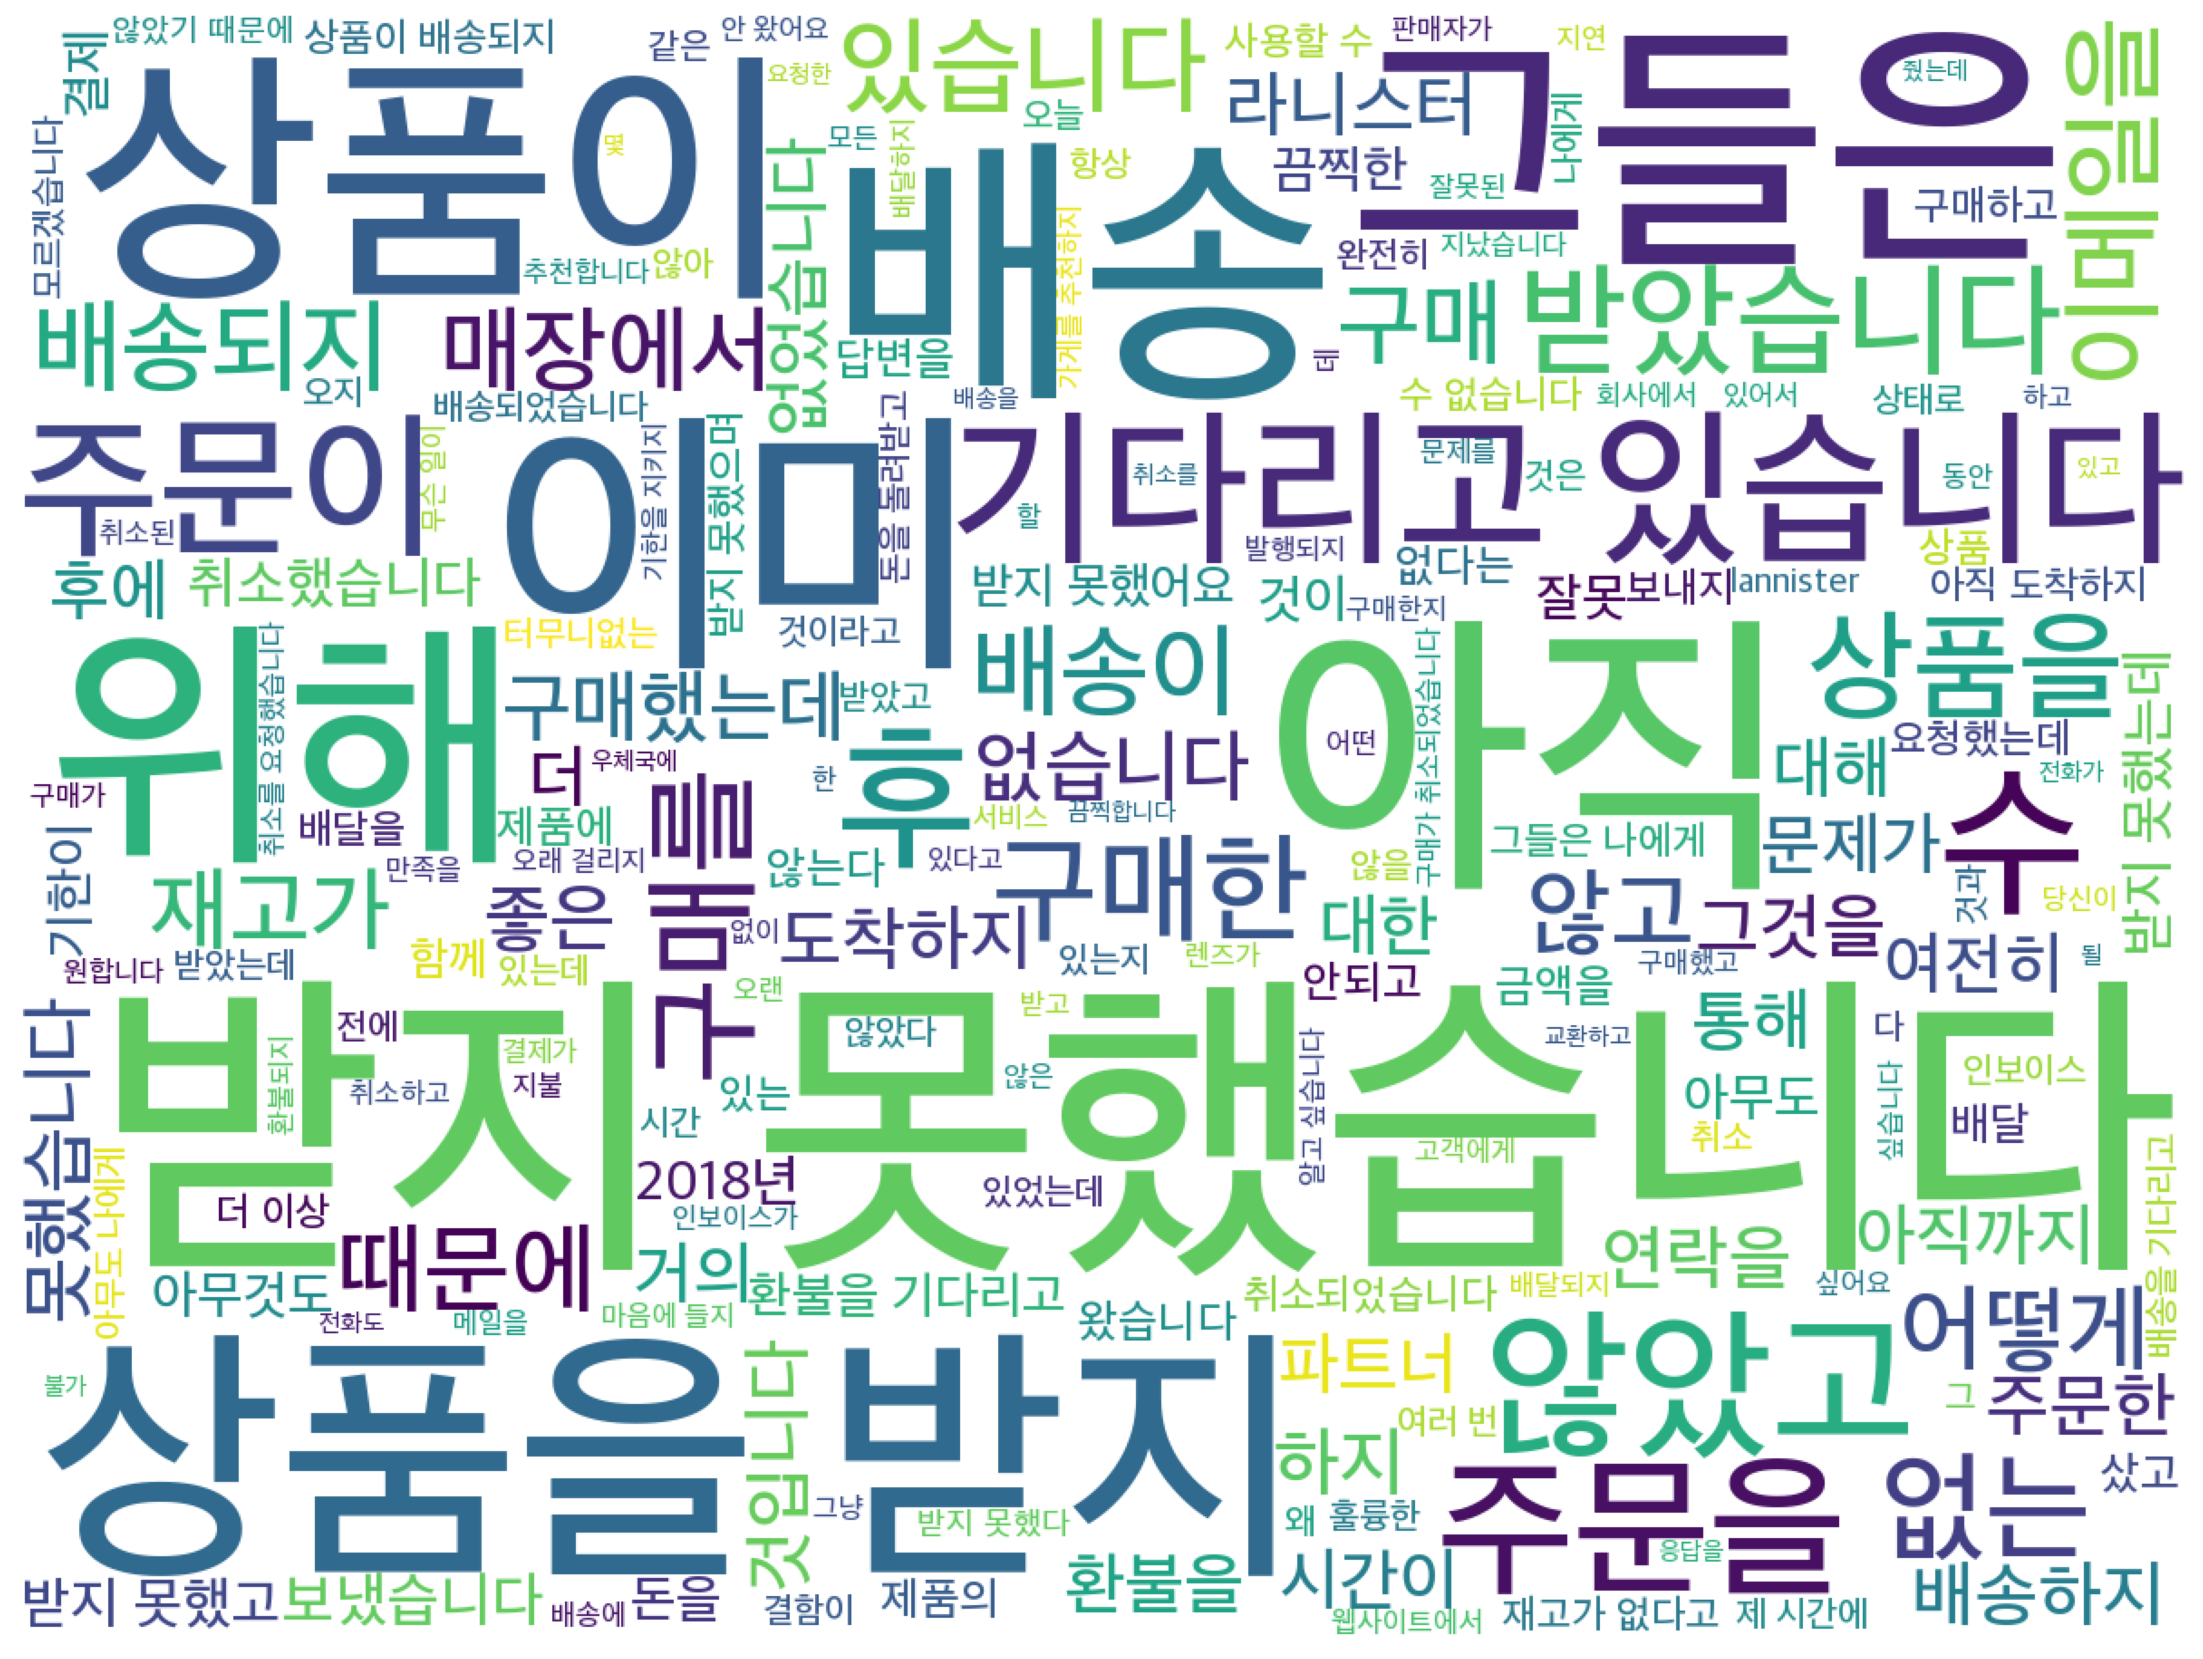

In [54]:
%time
displayWordCloud(' '.join(sentences01))

## 특정 단어를 포함하는 워드클라우드 생성하기 

In [56]:
p1 = r'.*(배송 | 실망 | 다시 | 지불 ).*'
collect01 = df[df['0'].str.match(p1)]
collect01.shape

(27, 1)

Wall time: 0 ns
Wall time: 0 ns


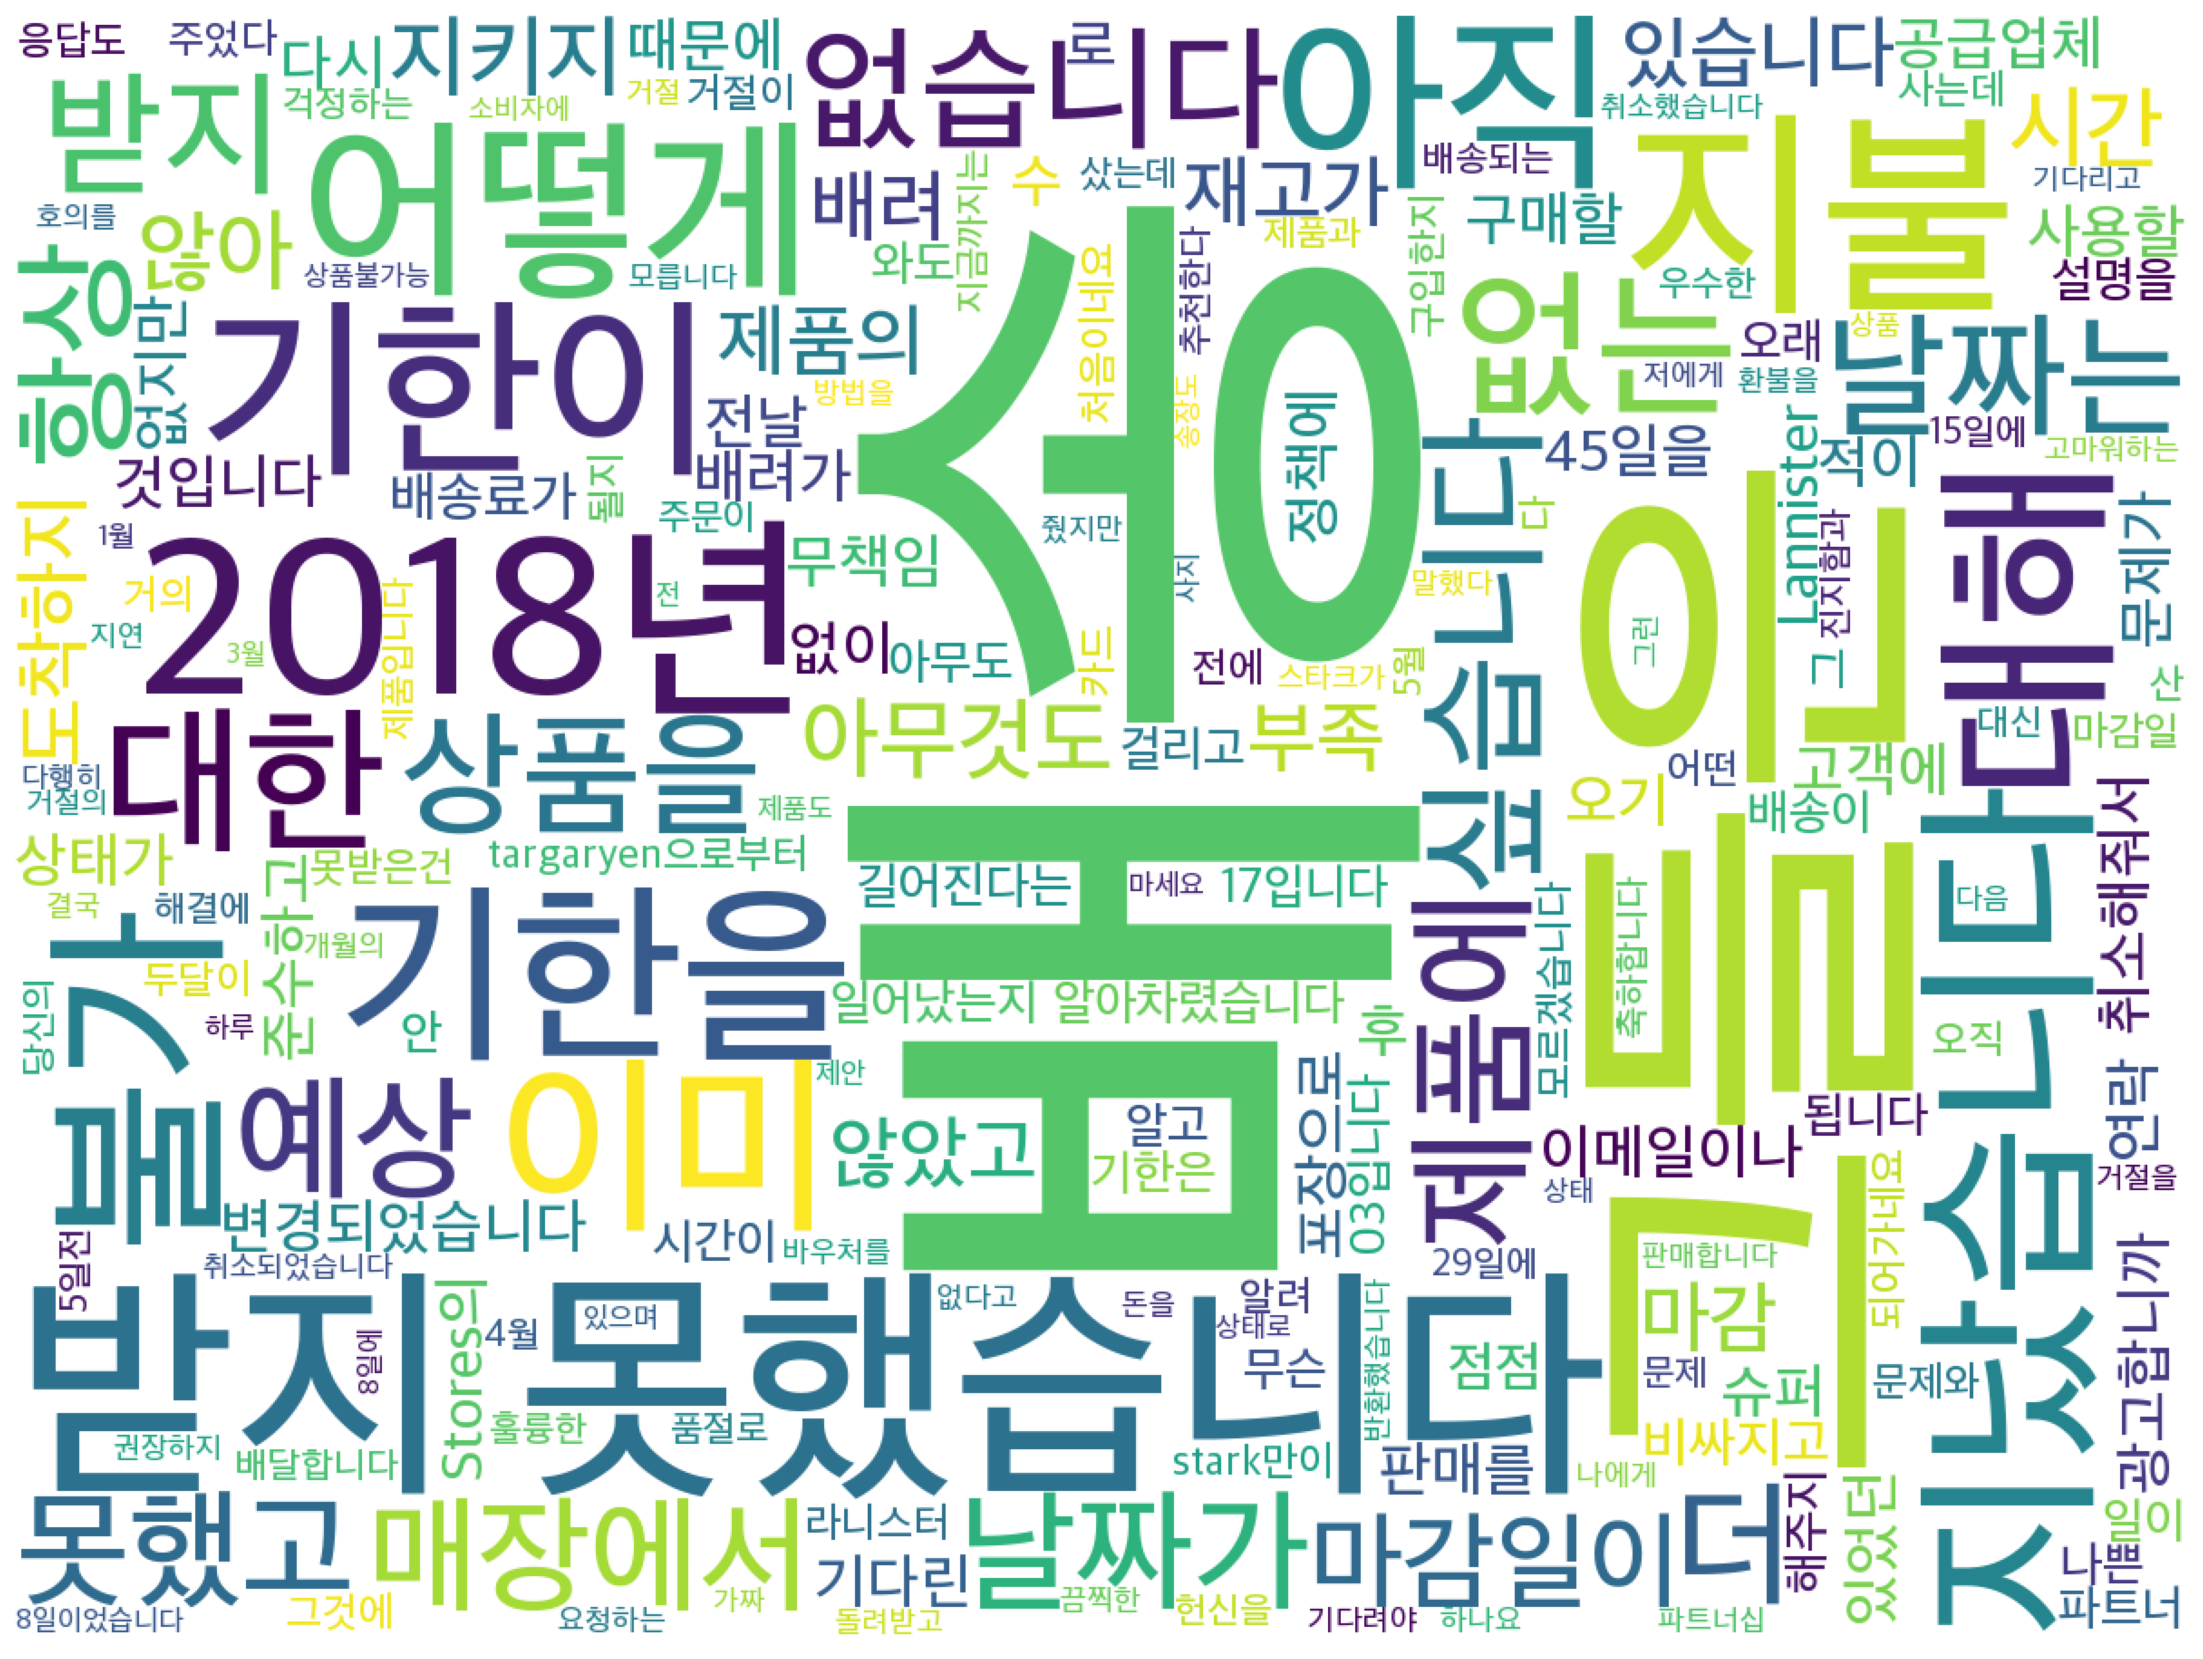

In [57]:
%time
col01 = collect01['0'].apply(preprocess)
%time
displayWordCloud(' '.join(col01))